In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install Bio --quiet
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('cafa-5-protein-function-prediction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Loading training dataset
train_terms = pd.read_csv('cafa-5-protein-function-prediction/Train/train_terms.tsv', sep='\t')
display(train_terms.head())

# Load training sequences
with open('cafa-5-protein-function-prediction/Train/train_sequences.fasta') as fasta_file:  # Will close handle cleanly
    identifiers = []
    lengths = []
    sequence = []
    seq_name = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        lengths.append(len(seq_record.seq))
        sequence.append(str(seq_record.seq))
        seq_name.append(seq_record.name)
        
train_seq_df = pd.DataFrame({'id': identifiers,
             'seq_length': lengths,
             'sequence': sequence,
             'seq_name': seq_name})
display(train_seq_df.head())

# Load training taxonomy terms
train_taxonomy = pd.read_csv('cafa-5-protein-function-prediction/Train/train_taxonomy.tsv', sep='\t')
train_taxonomy.head()

We will now load the pre calculated protein embeddings created by Sergei Fironov using the Rost Lab's T5 protein language model.

If the tfembeds is not yet on the input data of the notebook, you can add it to your enviromentby clicking on Add Data and search for t5embeds (make sure that it's the correct one ) and then click on the + beside it.

The protein embeddings to be used for training are recorded in train_embeds.npy and the corresponding protein ids are available in train_ids.npy.

In [ ]:
train_protein_ids = np.load('t5embeds/train_ids.npy')
display(train_protein_ids.shape)
train_protein_embeddings = np.load('t5embeds/train_embeds.npy')
display(train_protein_embeddings.shape)

column_num = train_protein_embeddings.shape[1]
train_embedding_df = pd.DataFrame(train_protein_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(train_embedding_df.shape)
display(pd.DataFrame(train_protein_ids, columns=['protein_id']).head())
display(train_embedding_df.head())

In order to simplify my model, I chose te most frequence 50 GO term IDs as labels.

In [ ]:
train_terms.head()

In [ ]:
# Select first 100 values for plotting
plot_df = train_terms['term'].value_counts().iloc[:100]
figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

In [ ]:
train_terms_updated,train_terms_test=train_test_split(train_terms, stratify=train_terms['aspect'], train_size=100, random_state=2)
train_terms_updated.shape[0]
num_of_labels=train_terms_updated.term.nunique()
labels = train_terms_updated.term.unique().tolist()

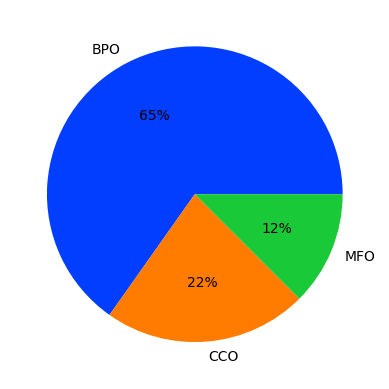

In [153]:
pie_df = train_terms['aspect'].value_counts()
palette_color = sns.color_palette('bright')
plt.pie(pie_df.values, labels=np.array(pie_df.index), colors=palette_color, autopct='%.0f%%')
plt.show()

In [169]:
# Set the limit for label
num_of_labels = 60

# Take value counts in descending order and fetch first 1500 `GO term ID` as labels
labels = train_terms.groupby('aspect').term.value_counts().reset_index()

grouped_df = labels.groupby('aspect')
label_ls = []
for name, group in grouped_df:
    if name == 'BPO':
        n_items = round(0.65*num_of_labels)
        label_ls.extend(group.head(n_items).term.tolist())
    elif name == 'CCO':
        n_items = round(0.22*num_of_labels)
        label_ls.extend(group.head(n_items).term.tolist())
    else:
        n_items = round(0.12*num_of_labels)
        label_ls.extend(group.head(n_items).term.tolist())
len(label_ls)
        
# Fetch the train_terms data for the relevant labels only
train_terms_updated = train_terms.loc[train_terms['term'].isin(label_ls)]

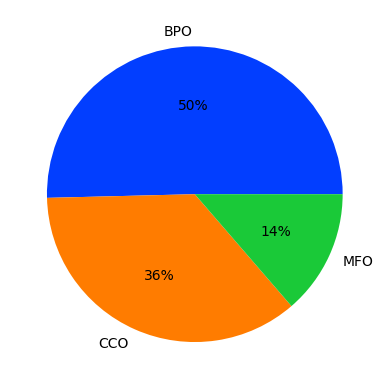

In [170]:
pie_df = train_terms_updated['aspect'].value_counts()
palette_color = sns.color_palette('bright')
plt.pie(pie_df.values, labels=np.array(pie_df.index), colors=palette_color, autopct='%.0f%%')
plt.show()

The subsampling maintains the same distribution as in the original dataset.
Since this is a multi label classification problem, in the labels array we will denote the presence or absence of each Go Term Id for a protein id using a 1 or 0.
First, we will create a numpy array `train_labels` of required size for the labels. To update the `train_labels` array with the appropriate values, we will loop through the label list.

Since this is a multi label classification problem, in the labels array we will denote the presence or absence of each Go Term Id for a protein id using a 1 or 0. First, we will create a numpy array train_labels of required size for the labels. To update the train_labels array with the appropriate values, we will loop through the label list.



In [175]:
# Create an empty dataframe of required size for storing the labels,
# i.e, train_size x num_of_labels (142246 x 500)
train_size = train_protein_ids.shape[0] # len(X), there are 142246 protein ids (that contain embeddings) for which 1500 Go terms need to be stored.
train_labels = np.zeros((train_size ,len(label_ls)))

# Convert from numpy to pandas series for better handling
series_train_protein_ids = pd.Series(train_protein_ids)

# Loop through each label
for i in range(len(label_ls)):
    # For each label, fetch the corresponding train_terms data
    n_train_terms = train_terms_updated[train_terms_updated['term'] ==  label_ls[i]]
    
    # Fetch all the unique EntryId aka proteins related to the current label(GO term ID)
    label_related_proteins = n_train_terms['EntryID'].unique()
    
    # In the series_train_protein_ids pandas series, if a protein is related
    # to the current label, then mark it as 1, else 0.
    # Replace the ith column of train_Y with with that pandas series.
    train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(int)
    

# Convert train_Y numpy into pandas dataframe
labels_df = pd.DataFrame(data = train_labels, columns = label_ls)
print(labels_df.shape)

(142246, 59)


In [176]:
labels_df.head()

,GO:0008150,GO:0009987,GO:0065007,GO:0050789,GO:0050794,GO:0050896,GO:0008152,GO:0032501,GO:0032502,GO:0071704,...,GO:0071944,GO:0005829,GO:0005886,GO:0003674,GO:0005488,GO:0005515,GO:0003824,GO:0097159,GO:1901363,GO:0003676
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


# Training and Testing with Neural Networks

In [ ]:
import tensorflow as tf

INPUT_SHAPE = [train_embedding_df.shape[1]]
BATCH_SIZE = 5120

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),    
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=num_of_labels,activation='sigmoid')
])


# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC()],
)

history = model.fit(
    train_embedding_df, labels_df,
    batch_size=BATCH_SIZE,
    epochs=5
)

# Plot the model's loss and accuracy for each epoch

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy']].plot(title="Accuracy")

# Submission

In [ ]:
test_embeddings = np.load('t5embeds/test_embeds.npy')

# Convert test_embeddings to dataframe
column_num = test_embeddings.shape[1]
test_df = pd.DataFrame(test_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(test_df.shape)

In [ ]:
predictions =  model.predict(test_df)
# This will take 15-20 minutes

In [ ]:
# Reference: https://www.kaggle.com/code/alexandervc/baseline-multilabel-to-multitarget-binary

df_submission = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])
test_protein_ids = np.load('/kaggle/input/t5embeds/test_ids.npy')
l = []
for k in list(test_protein_ids):
    l += [ k] * predictions.shape[1]   

df_submission['Protein Id'] = l
df_submission['GO Term Id'] = labels * predictions.shape[0]
df_submission['Prediction'] = predictions.ravel()
df_submission.to_csv("submission.tsv",header=False, index=False, sep="\t")

# Training and Testing with a Multilabel Classfier
Since many GO terms can be associated with each protein ID, I can think of this as multilabel classifier.
We will begin by coverting labels_df to a numpy sparse array

In [177]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [178]:
y = np.asarray(labels_df[labels_df.columns])

X_train, X_test, y_train, y_test = train_test_split(train_embedding_df, y, random_state = 2,)


In [179]:
log_reg_pipe = MultiOutputClassifier(LogisticRegression(random_state=2, solver='newton-cg'))
log_reg_pipe.get_params()


{'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': 2,
 'estimator__solver': 'newton-cg',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(random_state=2, solver='newton-cg'),
 'n_jobs': None}

In [181]:
parameters = [{'estimator__C':[0.01,1]}]
grid_search = GridSearchCV(estimator=log_reg_pipe ,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=3)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END .................estimator__C=0.01;, score=0.009 total time= 3.7min
[CV 2/5] END .................estimator__C=0.01;, score=0.008 total time= 3.7min
[CV 3/5] END .................estimator__C=0.01;, score=0.009 total time= 3.4min
[CV 4/5] END .................estimator__C=0.01;, score=0.010 total time= 3.2min
[CV 5/5] END .................estimator__C=0.01;, score=0.010 total time= 3.8min
[CV 1/5] END ....................estimator__C=1;, score=0.027 total time= 8.5min
[CV 2/5] END ....................estimator__C=1;, score=0.028 total time= 8.4min
[CV 3/5] END ....................estimator__C=1;, score=0.028 total time= 8.1min
[CV 4/5] END ....................estimator__C=1;, score=0.029 total time= 8.2min
[CV 5/5] END ....................estimator__C=1;, score=0.030 total time= 8.4min


GridSearchCV(cv=5,
             estimator=MultiOutputClassifier(estimator=LogisticRegression(random_state=2,
                                                                          solver='newton-cg')),
             param_grid=[{'estimator__C': [0.01, 1]}], scoring='accuracy',
             verbose=3)

In [196]:
# Get the best model
best_model = grid_search.best_estimator_
# Here you can replace pickle with joblib or cloudpickle
from pickle import dump
with open("log_reg.pkl", "wb") as f:
    dump(best_model, f, protocol=5)


In [184]:
predictions_log_reg = best_model.predict(X_test)

In [185]:
best_model.score(X_test, predictions_log_reg)

1.0

In [186]:
best_model.score(X_test, predictions_log_reg)
accuracy = np.mean(predictions_log_reg == y_test)
accuracy

0.8322838413503654

## Try one more model - Random Forest Classifier

In [193]:
from sklearn.ensemble import RandomForestClassifier
rand_f = MultiOutputClassifier(RandomForestClassifier(random_state=2))
rand_f.get_params()
rand_fparameters = [{'estimator__max_depth':[2, 5]}]
grid_search_rand = GridSearchCV(estimator=rand_f ,  
                           param_grid = rand_fparameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=3)

grid_search_rand.fit(X_train.head(n=1000), y_train[:1000])


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ............estimator__max_depth=2;, score=0.000 total time=  18.1s
[CV 2/5] END ............estimator__max_depth=2;, score=0.005 total time=  17.6s
[CV 3/5] END ............estimator__max_depth=2;, score=0.000 total time=  17.4s
[CV 4/5] END ............estimator__max_depth=2;, score=0.000 total time=  17.2s
[CV 5/5] END ............estimator__max_depth=2;, score=0.000 total time=  17.3s
[CV 1/5] END ............estimator__max_depth=5;, score=0.010 total time=  36.8s
[CV 2/5] END ............estimator__max_depth=5;, score=0.015 total time=  38.7s
[CV 3/5] END ............estimator__max_depth=5;, score=0.005 total time=  37.7s
[CV 4/5] END ............estimator__max_depth=5;, score=0.005 total time=  37.4s
[CV 5/5] END ............estimator__max_depth=5;, score=0.005 total time=  36.1s


GridSearchCV(cv=5,
             estimator=MultiOutputClassifier(estimator=RandomForestClassifier(random_state=2)),
             param_grid=[{'estimator__max_depth': [2, 5]}], scoring='accuracy',
             verbose=3)

In [195]:
# Get the best model
best_model_rand = grid_search_rand.best_estimator_

# Here you can replace pickle with joblib or cloudpickle
from pickle import dump
with open("rand.pkl", "wb") as f:
    dump(best_model_rand, f, protocol=5)

In [197]:
predictions_randf = best_model_rand.predict(X_test)
best_model_rand.score(X_test, predictions_randf)
accuracy = np.mean(predictions_randf == y_test)
accuracy

0.8113373730672333

## Ridge Classifier

In [204]:
from sklearn.linear_model import RidgeClassifier
ridge_csfr = MultiOutputClassifier(RidgeClassifier(solver='saga', random_state=2))
ridge_csfr.get_params()
ridge_csfr_parameters = [{'estimator__alpha':[0.1,1]}]
grid_search_ridge = GridSearchCV(estimator=ridge_csfr ,  
                           param_grid = ridge_csfr_parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=3)

grid_search_ridge.fit(X_train.head(n=1000), y_train[:1000])

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ..............estimator__alpha=0.1;, score=0.015 total time= 2.3min
[CV 2/5] END ..............estimator__alpha=0.1;, score=0.010 total time= 2.4min
[CV 3/5] END ..............estimator__alpha=0.1;, score=0.010 total time= 2.4min
[CV 4/5] END ..............estimator__alpha=0.1;, score=0.010 total time= 2.4min
[CV 5/5] END ..............estimator__alpha=0.1;, score=0.010 total time= 2.4min
[CV 1/5] END ................estimator__alpha=1;, score=0.025 total time=  26.7s
[CV 2/5] END ................estimator__alpha=1;, score=0.010 total time=  28.8s
[CV 3/5] END ................estimator__alpha=1;, score=0.020 total time=  28.1s
[CV 4/5] END ................estimator__alpha=1;, score=0.035 total time=  29.2s
[CV 5/5] END ................estimator__alpha=1;, score=0.010 total time=  30.7s


GridSearchCV(cv=5,
             estimator=MultiOutputClassifier(estimator=RidgeClassifier(random_state=2,
                                                                       solver='saga')),
             param_grid=[{'estimator__alpha': [0.1, 1]}], scoring='accuracy',
             verbose=3)

In [208]:
# Get the best model
best_model_ridge = grid_search_ridge.best_estimator_
# Here you can replace pickle with joblib or cloudpickle
best_model_ridge_full = best_model_ridge.fit(X_train, y_train)
from pickle import dump
with open("ridge.pkl", "wb") as f:
    dump(best_model_ridge_full, f, protocol=5)

KeyboardInterrupt: 

In [207]:
predictions_ridge = best_model_ridge.predict(X_test)
best_model_ridge.score(X_test, predictions_ridge)
accuracy = np.mean(predictions_ridge == y_test)
accuracy

0.8128758654019382

In [253]:
predictions_randf[:, i]

array([0., 0., 0., ..., 0., 0., 0.])

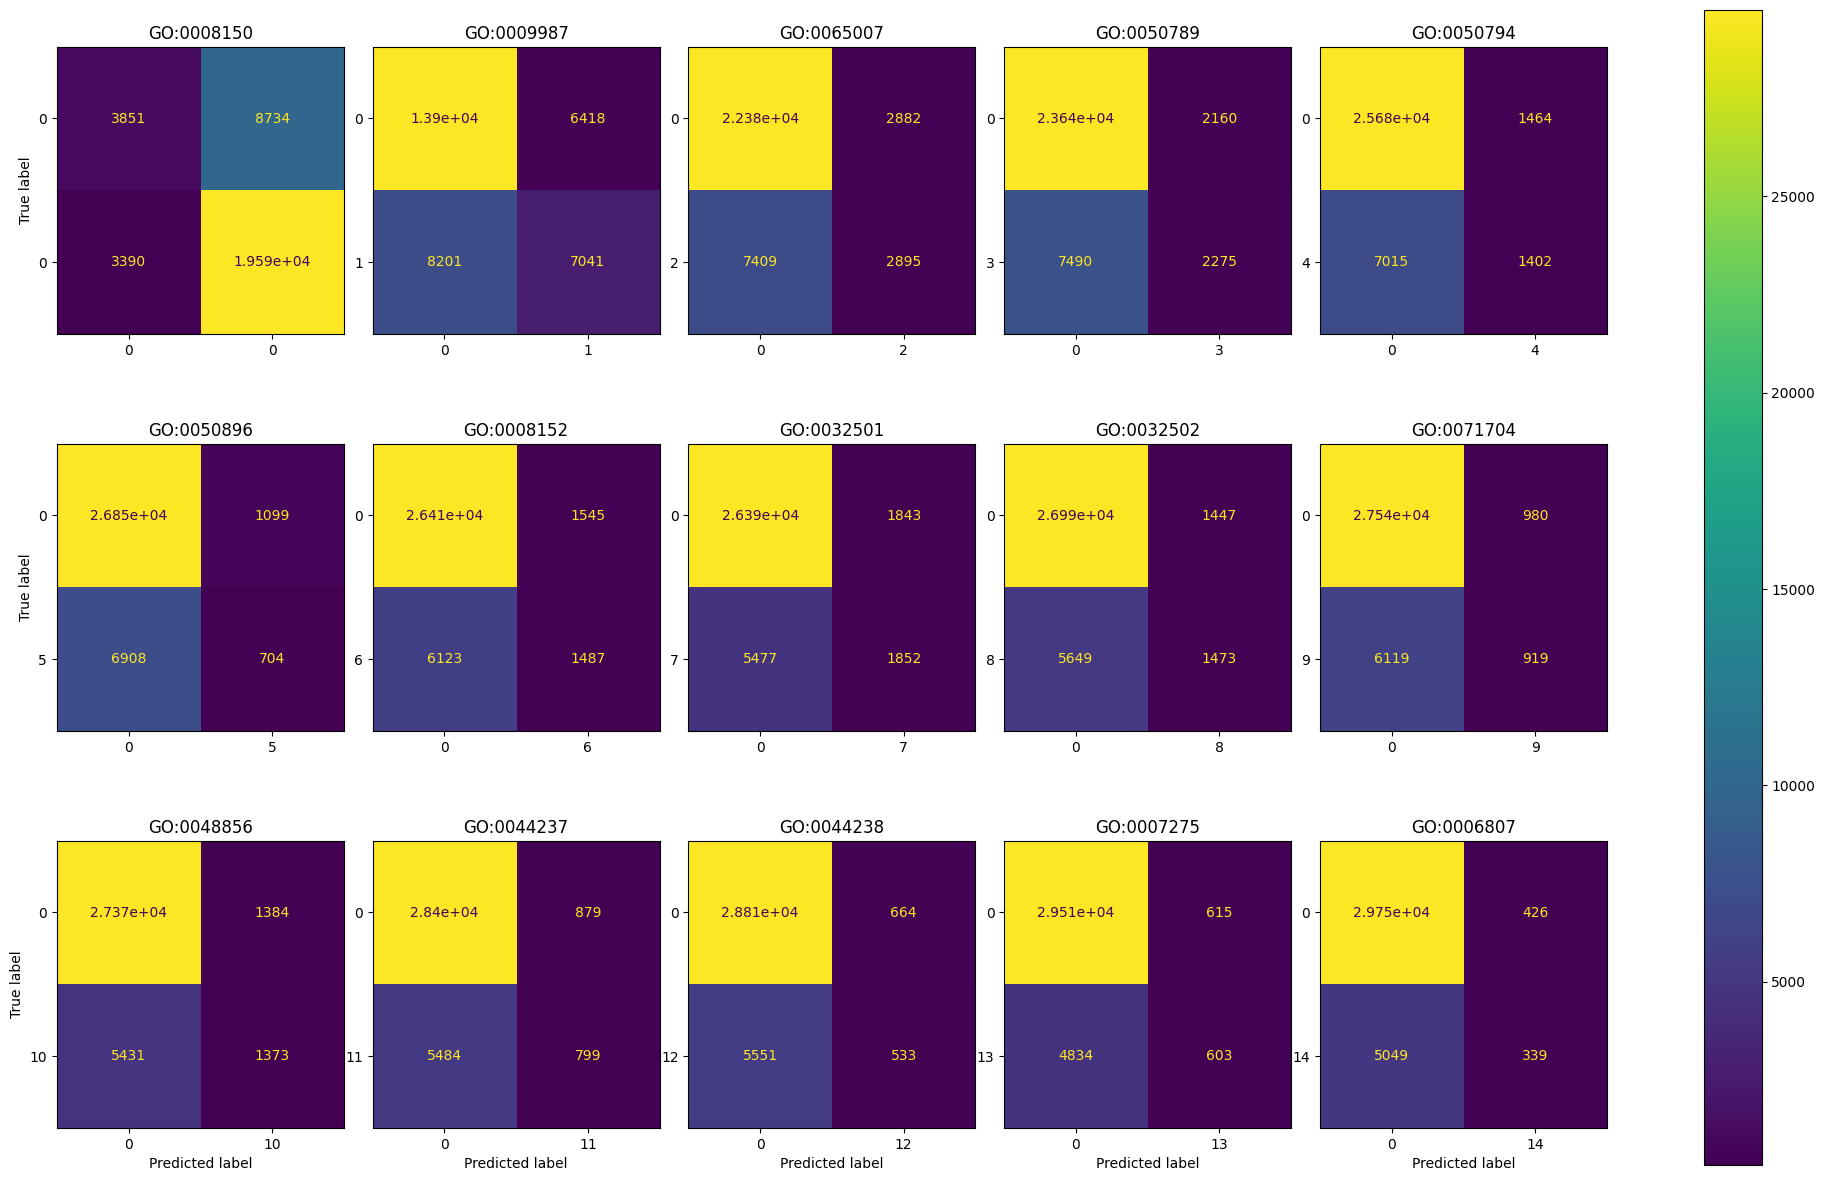

In [256]:
f, axes = plt.subplots(3, 5, figsize=(25, 15))
axes = axes.ravel()
for i in range(15):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test[:, i],
                                                   predictions_ridge[:, i]),
                                  display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(label_ls[i])
    # disp.ax_.set_title(f'GO Term {i}')
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [235]:
from sklearn.metrics import coverage_error
print('coverage error Ridge', coverage_error(y_test, predictions_ridge))
print('coverage error Log Reg', coverage_error(y_test, predictions_log_reg))
print('coverage error Random Forest', coverage_error(y_test, predictions_randf))

coverage error Ridge 53.88864518306057
coverage error Log Reg 52.092373882233844
coverage error Random Forest 56.91848040042742


In [242]:
from sklearn.metrics import f1_score
f1_score(y_test, predictions_ridge, average=None)

array([0.7636555 , 0.49064493, 0.36005224, 0.32042254, 0.24851547,
       0.14954859, 0.27945875, 0.33599419, 0.29336786, 0.20566186,
       0.28720845, 0.20072855, 0.14640846, 0.18121713, 0.11019015,
       0.04893657, 0.24196066, 0.04267198, 0.00895331, 0.09654615,
       0.10804224, 0.23091703, 0.01484319, 0.02768166, 0.01067616,
       0.17868817, 0.20894892, 0.00691306, 0.00658075, 0.18516028,
       0.01242236, 0.23194654, 0.04449327, 0.01922517, 0.01616283,
       0.01204094, 0.0304878 , 0.01539883, 0.04011282, 0.75797784,
       0.75191531, 0.66666667, 0.58242297, 0.56910993, 0.53451887,
       0.52730505, 0.52458737, 0.40220975, 0.29795118, 0.20150746,
       0.08592955, 0.16663337, 0.65233793, 0.51359581, 0.4522438 ,
       0.39147492, 0.13280632, 0.13315579, 0.16565785])

In [247]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
print('Precision Recall Support Ridge',precision_recall_fscore_support(y_test, predictions_ridge, average='weighted'))
print('Precision Recall Support Log Reg',precision_recall_fscore_support(y_test, predictions_log_reg, average='weighted'))
print('Precision Recall Support Random Forest',precision_recall_fscore_support(y_test, predictions_randf, average='weighted'))

Precision Recall Support Ridge (0.5254303455612582, 0.37302963906277625, 0.3964395295268212, None)
Precision Recall Support Log Reg (0.6378197577452935, 0.43857442441848754, 0.47189914105192704, None)
Precision Recall Support Random Forest (0.5665935013947065, 0.2699833709705937, 0.2592235035912035, None)


/Users/vaishnavin/Desktop/AIML_Berkeley/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
